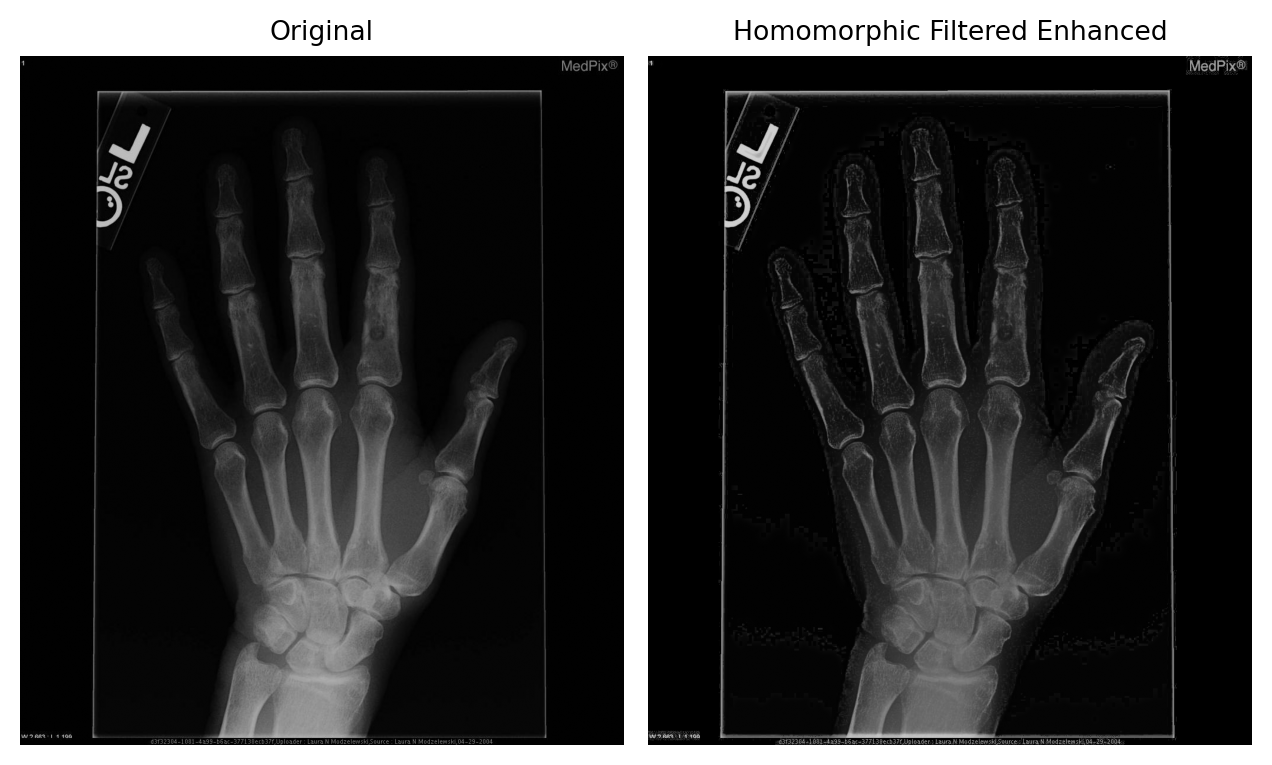

In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import requests
from PIL import Image


# 1. Load grayscale image
#img = img.astype(np.float32) / 255.0  # normalize [0,1]

matplotlib.rcParams['font.size'] = 8

# Load an example image
#img = data.moon()
# Get an image
# Using the same image URL from the original cell for consistency
image_url = "https://d2rfm59k9u0hrr.cloudfront.net/medpix/img/full/synpic19850.jpg"
response = requests.get(image_url, stream=True)
response.raise_for_status()

# Save the image to a file
image_path = "medical_image.jpg"
with open(image_path, 'wb') as out_file:
    out_file.write(response.content)

# Load the image
orig_img_rgb = Image.open(image_path)

# Convert the RGB image to grayscale
# There are several ways to convert to grayscale. One common method is using the luminosity formula:
# Gray = 0.2989*R + 0.5870*G + 0.1140*B
# PIL provides a direct convert method as well
orig_img = orig_img_rgb.convert('L')
img = np.array(orig_img)#[500: 1000, 500:1000]


# 2. Apply log transform
log_img = np.log1p(img)

# 3. Perform FFT and shift
fft = np.fft.fft2(log_img)
fft_shift = np.fft.fftshift(fft)

# 4. Construct Homomorphic filter (Gaussian high-pass)
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2
D0 = 30.0   # cutoff frequency
H = np.zeros((rows, cols), dtype=np.float32)

for u in range(rows):
    for v in range(cols):
        D = np.sqrt((u - crow)**2 + (v - ccol)**2)
        H[u, v] = 1 - np.exp(-(D**2) / (2 * (D0**2)))  # high-pass

# 5. Apply filter
filtered_fft = fft_shift * H

# 6. Inverse FFT
ifft_shift = np.fft.ifftshift(filtered_fft)
img_filtered = np.fft.ifft2(ifft_shift)
img_filtered = np.real(img_filtered)

# 7. Exponentiate to restore
img_homomorphic = np.expm1(img_filtered)
img_homomorphic = np.clip(img_homomorphic, 0, 1)

# 8. Show results
plt.figure(dpi=200)
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Homomorphic Filtered Enhanced")
plt.imshow(img+100*img_homomorphic, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig("homomorphic_filtering.png")
plt.show()
